In [1]:
import os

import pandas as pd

from CheXpert2 import names
%matplotlib inline
import cv2 as cv
from CheXpert2.dataloaders.CXRLoader import CXRLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Step 1 : Initiating the dataset

Since we don't train the model, we only need one dataset

In [2]:
img_dir="/mnt/f/IA-med_img"
channels=1
dataset = CXRLoader(
            split="Valid",
            img_dir=img_dir,
            img_size=800,
            prob=[1,1,1,1,1],
            label_smoothing=0,
            channels=channels,
            use_frontal=False,
            datasets=["ChexPert"],
            debug=True
        )
i=0

/mnt/f/IA-med_img/CheXpert2/dataloaders/CXRLoader.py:169: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby("Exam ID").mean().round(0)


# Step 2 : Assert the dataloader is working ; Require the images on the device

/tmp/ipykernel_6608/2686037186.py:35: RuntimeWarning: invalid value encountered in divide
  img2 = (img2-np.min(img2)) / (np.max(img2)-np.min(img2))*255


[0.         0.27191401 1.         0.32544038]
[-1.9867257 -0.783566   2.4380531  1.4400023]
Regardons maintenant les vaeurs de nos images
        min      mean       max       std
0 -1.969374  0.419593  2.438053  73.41352
1 -1.986726 -1.986725 -1.986726  73.41352


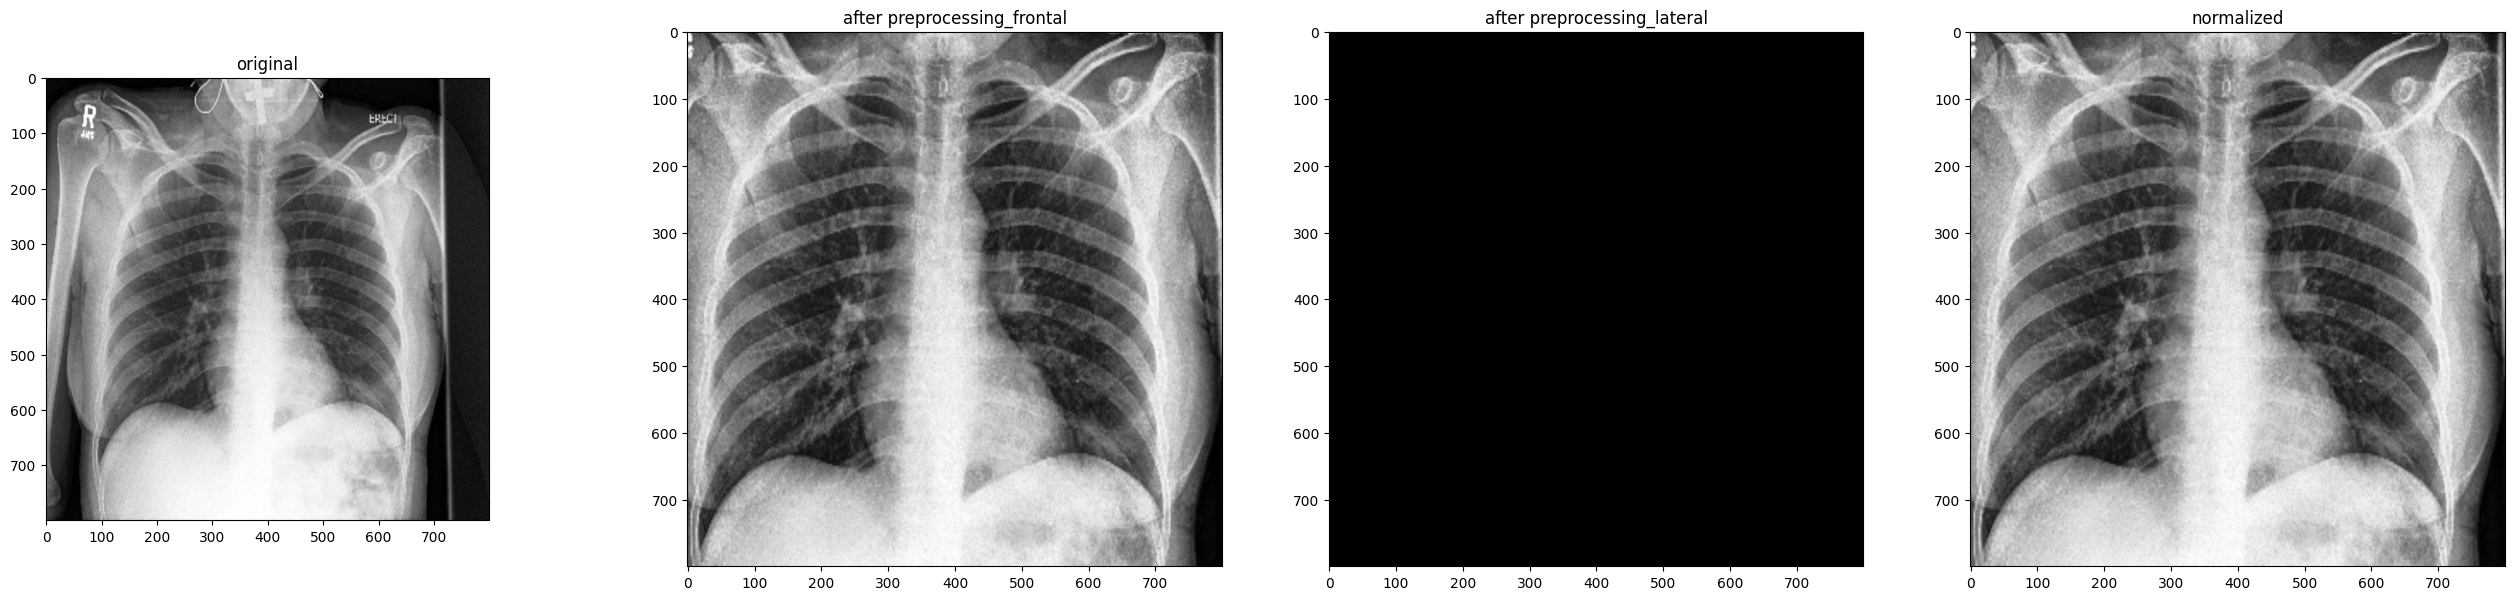

In [3]:
image = dataset.read_img_from_disk(dataset.files.at[3,"Path"])[:,:,int(0*channels):int((0+1)*channels)].squeeze()

titles =[
    "original",
    "after preprocessing_frontal",
    "after preprocessing_lateral",
    "normalized",
    "clahe1",
    "clahe2",
]
fig = plt.figure(figsize=(40, 40))
img = cv.resize(np.array(Image.open(f"{dataset.img_dir}{dataset.files.at[3,'Path'][0]}")),(800,800))
fig.add_subplot(1, 6, 1)
plt.imshow(img,cmap="gray")
plt.title(titles[0])
fig.add_subplot(1, 5, 2)
img2= (dataset[3][0][:,:,:]).numpy()
print("Regardons maintenant les vaeurs de nos images")
data=np.zeros((len(img2),4))
for ex,im in enumerate(img2) :
    data[ex] = np.array([np.min(im),np.mean(im),np.max(im),np.std(img)])


print(pd.DataFrame(data,columns=["min","mean","max","std"]))
img22=np.transpose(img2[channels : 2*channels],(1,2,0))
img2=np.transpose(img2[0:channels],(1,2,0))
img2 = (img2-np.min(img2)) / (np.max(img2)-np.min(img2))*255
img2 = img2.astype(np.uint8)
plt.imshow(img2,cmap="gray")
plt.title(titles[1])
#----------------
fig.add_subplot(1, 5, 3)
img2 = img22

img2 = (img2-np.min(img2)) / (np.max(img2)-np.min(img2))*255
img2 = img2.astype(np.uint8)
plt.imshow(img2,cmap="gray")
plt.title(titles[2])
if channels==1 :
    ex=4
    image = cv.cvtColor(image.astype(np.uint8), cv.COLOR_GRAY2RGB)
    img = Image.fromarray(image.astype(np.uint8))
    fig.add_subplot(1, 5, ex)
    plt.imshow(img,cmap="gray")
    plt.title(titles[ex-1])
else :

    ex=3
    _,_,c=image.shape
    for i in range(c) :
        img = image[:,:,i]
        fig.add_subplot(1, 5, ex)
        plt.imshow(img,cmap="gray")
        plt.title(titles[ex-1])
        ex+=1

plt.show()

/tmp/ipykernel_6608/733223040.py:10: RuntimeWarning: invalid value encountered in divide
  image = (image - np.min(image))/(np.max(image)-np.min(image))


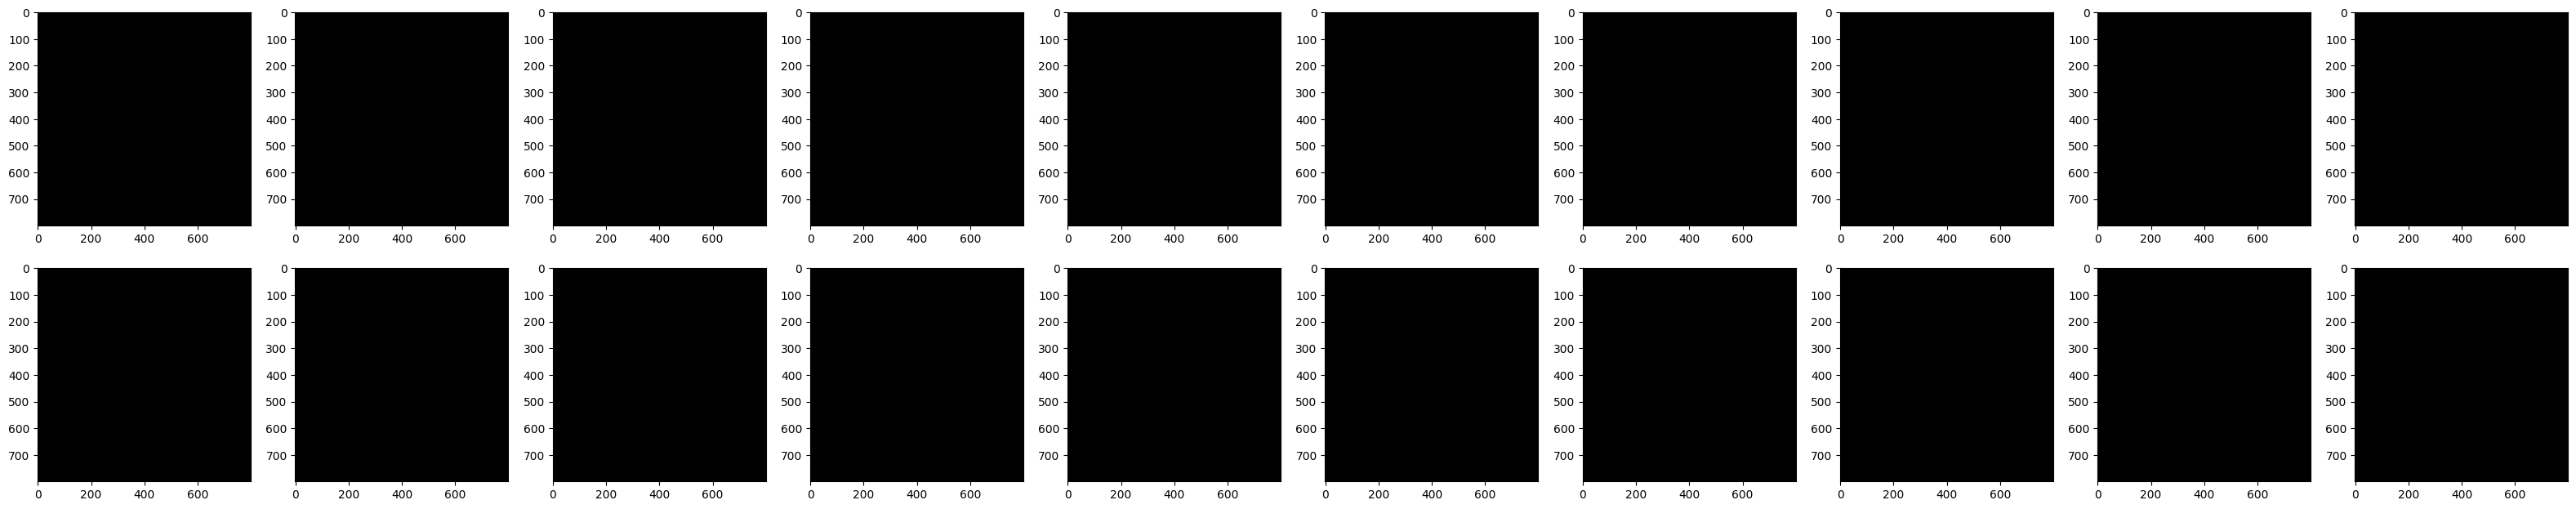

In [4]:
import time
ex=1
fig = plt.figure(figsize=(40, 40))
for i in range(10,20) :
    images  = dataset.read_img_from_disk(dataset.files.at[i,"Path"])

    for j in range(0,2) :
        image = images[:,:,int(j*channels):int((j+1)*channels)].squeeze()

        image = (image - np.min(image))/(np.max(image)-np.min(image))
        if len(image.shape)==2 :
            image = cv.cvtColor(image.astype(np.uint8), cv.COLOR_GRAY2RGB)



            #image = cv.cvtColor(image.astype(np.uint8), cv.COLOR_RGB2GRAY)
        fig.add_subplot(10, 10, ex)
        ex+=1
        plt.imshow(image,cmap="gray")




# Step 2.2 : We can test the data augmentations !

In [5]:
import albumentations as A
import cv2 as cv
#image  = A.augmentations.geometric.transforms.Affine(scale=(0.95,1.05),translate_percent=(0.05,0.05),rotate=(-15,15),shear=None,cval=0,keep_ratio=True,p=1)(image=np.array(frontal_image)[:,:,None])["image"]

# image  = A.augmentations.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, always_apply=False,p=1)(image=np.array(frontal_image)[:,:,None])["image"]

image = A.GridDistortion(num_steps=1,distort_limit=0.3,interpolation=1,border_mode=0,value=None,mask_value=None,always_apply=False,p=1)(image=np.array(frontal_image)[:,:,None])["image"]

# image = A.ElasticTransform(alpha=0.2, sigma=25, alpha_affine=50, interpolation=1, value=None,p=1, border_mode=cv.BORDER_CONSTANT)(image=np.array(frontal_image)[:,:,None])["image"]

image = Image.fromarray(image.squeeze())

image.show()

NameError: name 'frontal_image' is not defined

# Step 3 : Let's now plot some information about the dataset

In [ ]:

data = np.concatenate([dataset.count.reshape((1,18)),dataset.count.reshape((1,18))/len(dataset)])
data = pd.DataFrame(data,columns=names,index=["Count","Ratio"])
print(data)


In [ ]:
plt.bar(x=range(0,len(names)),height=dataset.count,label=names)
plt.show()

# Let's now verify the dataloader ; does it extract the classes as we want to?

In [ ]:
import torch
%matplotlib inline
second_image_count=0


labels=torch.zeros((len(names)))

for image,label,idx in dataset :
    if torch.max(image[1])==0 :
        second_image_count+=1

    labels+=label

print("The ratio of images with a second image : ", second_image_count/len(dataset))
plt.bar(x=range(0,len(names)),height=labels,label=names)
plt.show()